In [112]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
import random
import seaborn as sns
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer,Conv2D,MaxPool2D,Flatten,Dropout,Dense, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1_l2,l1,l2
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
cd /content/drive/MyDrive/DeepLearning/

/content/drive/MyDrive/DeepLearning


In [115]:
ls

checkpoint_mejor_modelo_v2.h5  fully_covered.pkl  not_face.pkl
checkpoint_mejor_modelo_v3.h5  not_covered.pkl    partially_covered.pkl


In [116]:
infile=open('partially_covered.pkl', 'rb')
X_partially_covered=pickle.load(infile)
infile.close()

infile=open('not_face.pkl', 'rb')
X_not_face=pickle.load(infile)
infile.close()

infile=open('not_covered.pkl', 'rb')
X_not_covered=pickle.load(infile)
infile.close()

infile=open('fully_covered.pkl', 'rb')
X_fully_covered=pickle.load(infile)
infile.close()

In [117]:
X_partially_covered=np.array(X_partially_covered)
X_not_face=np.array(X_not_face)
X_not_covered=np.array(X_not_covered)
X_fully_covered=np.array(X_fully_covered)

print(f"Partially covered shape: {X_partially_covered.shape}")
print(f"Not face shape: {X_not_face.shape}")
print(f"Not covered shape: {X_not_covered.shape}")
print(f"Fully covered shape: {X_fully_covered.shape}")

Partially covered shape: (392, 64, 64)
Not face shape: (1114, 64, 64)
Not covered shape: (3664, 64, 64)
Fully covered shape: (1451, 64, 64)


In [118]:
X=np.concatenate((X_not_covered,X_fully_covered),axis=0)
Y=np.concatenate((np.repeat(0, X_not_covered.shape[0]),np.repeat(1, X_fully_covered.shape[0])),axis=0).reshape(-1,1)
one = OneHotEncoder()
Y=one.fit_transform(Y).toarray()

In [119]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.15/(1-0.1),random_state=1)

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [120]:
checkpoints = ModelCheckpoint(
                            "checkpoint_mejor_modelo_v2.h5",
                            monitor='val_loss', ## que funcion monitorea para crear el checkpoint
                            verbose=10, ## imprima que guardo un checkpoint
                            save_best_only=True, ## solo guarde el mejor model
                            save_weights_only=False, ## Nos guarda la arquitectura y los pesos
                            mode="min", ### Cuando guardar el checkpoint, en este caso, cada nuevo minimo en la funcion de val_loss
                            save_freq='epoch') ### Cada cuando guarda el checkpoint


In [135]:
model = Sequential()
model.add(InputLayer(input_shape=(64,64,1))) ## las dimensiones de la imagen
model.add(Conv2D(filters= 16 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Dropout(0.2))
model.add(Conv2D(filters= 32 , kernel_size=(3,3),strides=(1,1), padding="same", activation = "sigmoid" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid'))  
model.add(Conv2D(filters= 64 , kernel_size=(2,2),strides=(1,1), padding="same", activation = "relu" ))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid')) 
model.add(Flatten()) ## convetimos un tensor de cualesquiera dimensiones a un vector 
model.add(Dropout(0.2))
model.add(Dense(units=256, activation ="relu"))
model.add(Dense(units=128, activation ="sigmoid"))
model.add(Dense(units=64, activation ="relu", kernel_regularizer= l1_l2(0.01,0.01)))
model.add(Dense(2, activation="softmax"))

model.compile(loss=BinaryCrossentropy(), optimizer=Adam(0.0001,), metrics= ["accuracy"])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 64, 64, 16)        80        
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 32, 32, 16)        0         
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 16, 16, 64)      

In [136]:
history = model.fit(X_train,Y_train, epochs= 100, batch_size =64, validation_data=(X_val,Y_val),callbacks=[checkpoints])


Epoch 1/100
58/60 [============================>.] - ETA: 0s - loss: 8.5062 - accuracy: 0.6926
Epoch 1: val_loss did not improve from 0.22602
60/60 [==============================] - 2s 23ms/step - loss: 8.4964 - accuracy: 0.6941 - val_loss: 8.1966 - val_accuracy: 0.7266
Epoch 2/100
57/60 [===========================>..] - ETA: 0s - loss: 7.9566 - accuracy: 0.7168
Epoch 2: val_loss did not improve from 0.22602
60/60 [==============================] - 1s 17ms/step - loss: 7.9435 - accuracy: 0.7173 - val_loss: 7.6684 - val_accuracy: 0.7266
Epoch 3/100
59/60 [============================>.] - ETA: 0s - loss: 7.4228 - accuracy: 0.7193
Epoch 3: val_loss did not improve from 0.22602
60/60 [==============================] - 1s 17ms/step - loss: 7.4205 - accuracy: 0.7173 - val_loss: 7.1542 - val_accuracy: 0.7266
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 6.9152 - accuracy: 0.7173
Epoch 4: val_loss did not improve from 0.22602
60/60 [==============================] - 1

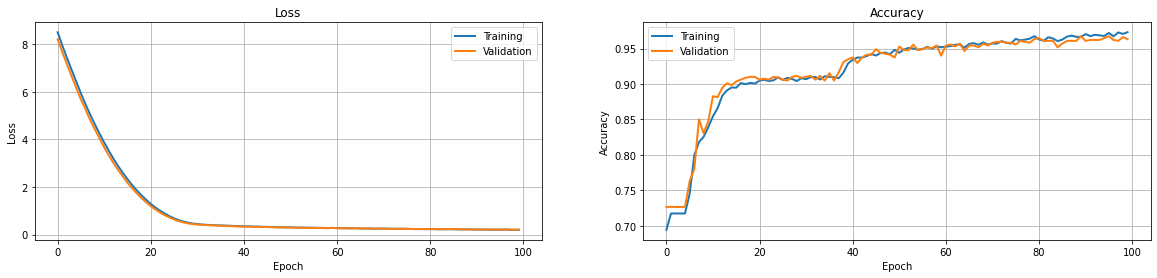

In [137]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(model.history.history['loss'], label='Training', linewidth=2)
plt.plot(model.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(model.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(model.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [138]:
best_model = load_model("checkpoint_mejor_modelo_v2.h5")

In [139]:
test_loss = best_model.evaluate(x=X_test, y=Y_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.2268 - accuracy: 0.9609


In [140]:
Y_test_hat = best_model.predict(x=X_test)

Y_test_hat_cat = np.argmax(Y_test_hat, axis=1)
Y_test_cat = np.argmax(Y_test, axis=1)
cm=confusion_matrix(y_true=Y_test_cat, y_pred=Y_test_hat_cat)

print(cm)
print("\n")
print(np.round(np.transpose(np.transpose(cm)/cm.sum(axis=1)),3)*100)

[[347   8]
 [ 12 145]]


[[97.7  2.3]
 [ 7.6 92.4]]


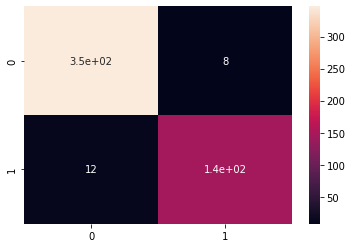

In [141]:
import seaborn as sns
sns.heatmap(cm, annot=True)

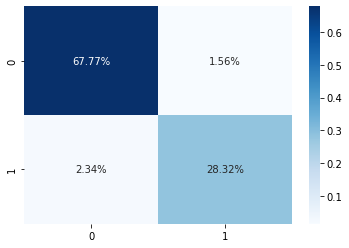

In [142]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [143]:
ypred = model.predict(X_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(Y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 512 	accurately-predicted-data: 488 	 wrongly-predicted-data:  24
Accuracy: 95.312 %


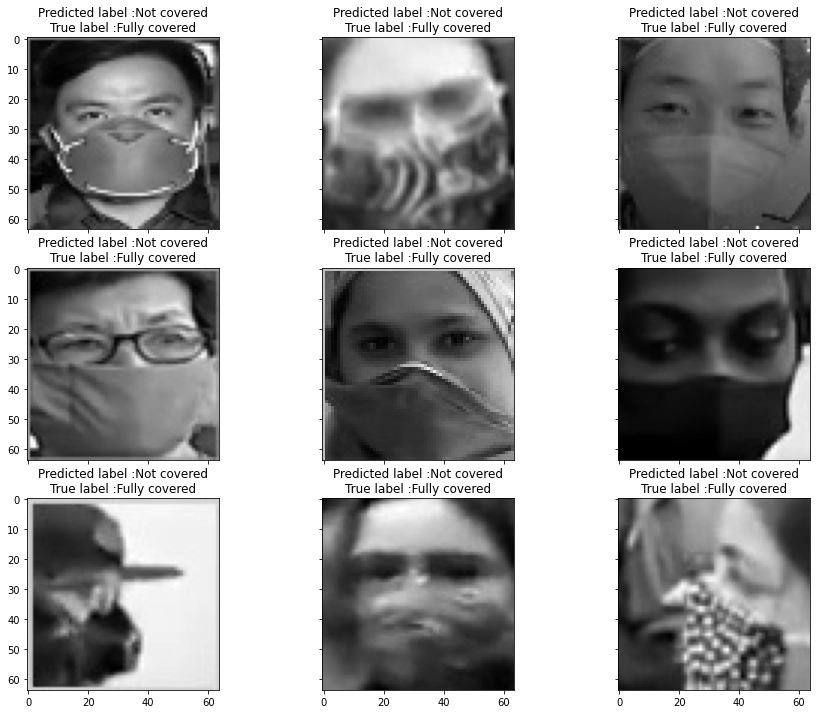

In [144]:
label=['Not covered', 'Fully covered']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(X_test[imidx[n]], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(Y_test[imidx[n]])]))
            n += 1

plt.show()

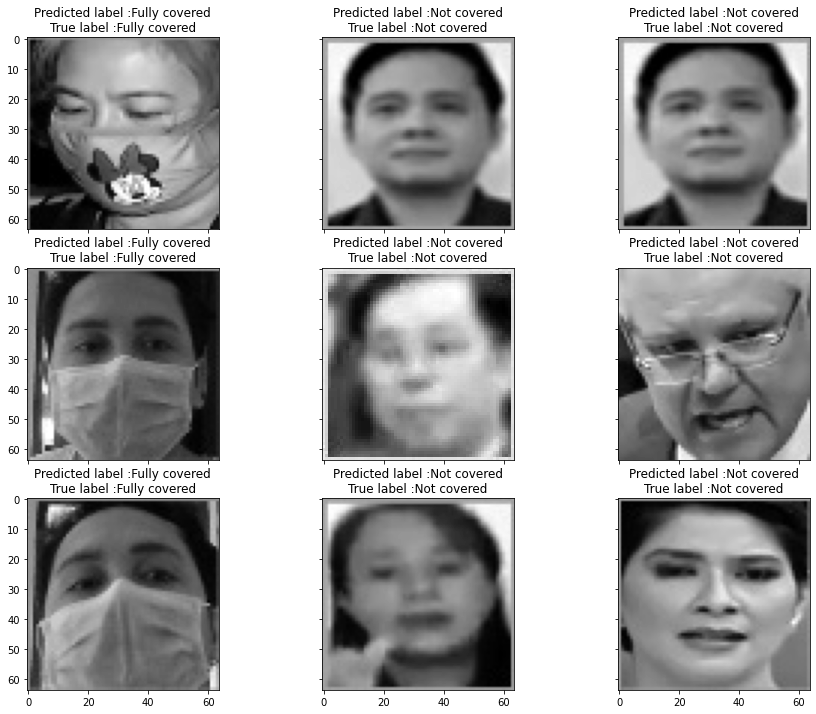

In [145]:
label=['Not covered', 'Fully covered']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(X_test[imidx[n]], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(Y_test[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

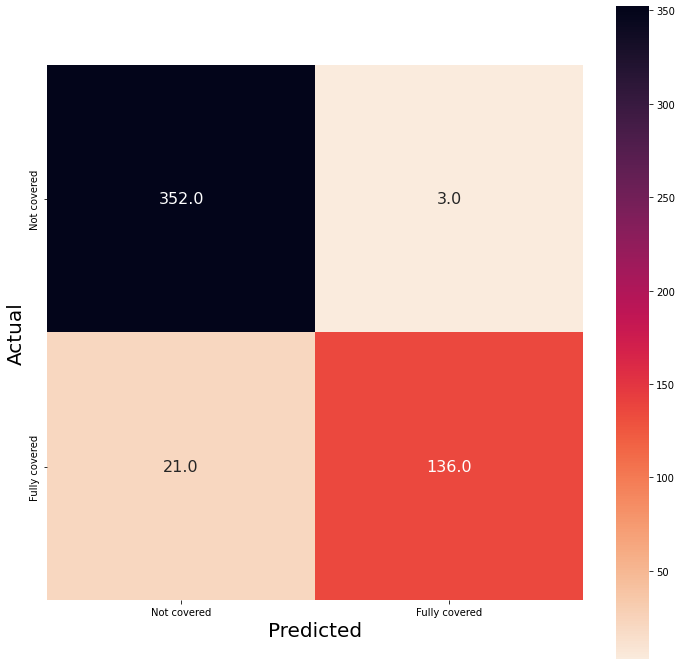

In [146]:
Ypred = model.predict(X_test)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [149]:
from sklearn.metrics import classification_report

In [150]:
print(classification_report(Ytrue, Ypred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       355
           1       0.98      0.87      0.92       157

    accuracy                           0.95       512
   macro avg       0.96      0.93      0.94       512
weighted avg       0.95      0.95      0.95       512

